In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.backend import resize_images
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

### Load data

In [3]:
features = np.load('features_facenet.npy')
labels = np.load('../data/labels.npy')

In [4]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.3)

In [5]:
print(f'Train:  0: {len(y_train[y_train < 60])}, 1: {len(y_train[y_train > 60])}')
print(f'Test:   0: {len(y_test[y_test < 60])}, 1: {len(y_test[y_test > 60])}')

Train:  0: 14774, 1: 1631
Test:   0: 6244, 1: 766


In [6]:
y_train = np.array([0 if label < 60 else 1 for label in  y_train])
y_test = np.array([0 if label < 60 else 1 for label in  y_test])

### Define model

In [7]:
# Softmax regressor to classify images based on encoding 
classifier_model=Sequential()
classifier_model.add(Dense(units=100,input_dim=features.shape[1],kernel_initializer='glorot_uniform'))
classifier_model.add(BatchNormalization())
classifier_model.add(Activation('tanh'))
classifier_model.add(Dropout(0.3))
classifier_model.add(Dense(units=10,kernel_initializer='glorot_uniform'))
classifier_model.add(BatchNormalization())
classifier_model.add(Activation('tanh'))
classifier_model.add(Dropout(0.2))
classifier_model.add(Dense(units=2,kernel_initializer='he_uniform'))
classifier_model.add(Activation('softmax'))
classifier_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer='nadam',
    metrics=['accuracy'])

In [8]:
classifier_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               262300    
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10)                40        
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0

### Initialize dataset

In [9]:
x_train.shape

(16595, 2622)

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [11]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
EPOCHS = 7

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Learn model

In [12]:
history = classifier_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset
)

Train for 260 steps, validate for 112 steps
Epoch 1/7
260/260 [==============================] - 3s 10ms/step - loss: 0.3692 - accuracy: 0.8613 - val_loss: 0.2259 - val_accuracy: 0.9223
Epoch 2/7
260/260 [==============================] - 1s 5ms/step - loss: 0.1879 - accuracy: 0.9354 - val_loss: 0.1499 - val_accuracy: 0.9390
Epoch 3/7
260/260 [==============================] - 1s 5ms/step - loss: 0.1524 - accuracy: 0.9425 - val_loss: 0.1552 - val_accuracy: 0.9395
Epoch 4/7
260/260 [==============================] - 1s 5ms/step - loss: 0.1390 - accuracy: 0.9436 - val_loss: 0.1421 - val_accuracy: 0.9418
Epoch 5/7
260/260 [==============================] - 1s 5ms/step - loss: 0.1309 - accuracy: 0.9470 - val_loss: 0.1427 - val_accuracy: 0.9417
Epoch 6/7
260/260 [==============================] - 1s 5ms/step - loss: 0.1281 - accuracy: 0.9469 - val_loss: 0.1423 - val_accuracy: 0.9412
Epoch 7/7
260/260 [==============================] - 1s 5ms/step - loss: 0.1223 - accuracy: 0.9498 - val_loss

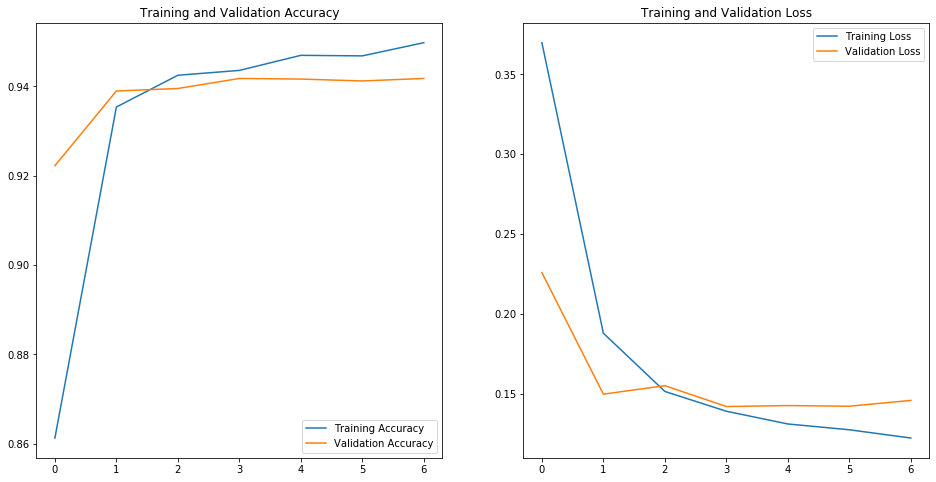

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
prob = classifier_model.predict(x_test)

In [15]:
prob = prob.argmax(axis=1)

In [16]:
print(classification_report(prob, y_test))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      6406
           1       0.67      0.82      0.74       707

    accuracy                           0.94      7113
   macro avg       0.82      0.89      0.85      7113
weighted avg       0.95      0.94      0.94      7113

